# Problem set 1 - Solutions

## Problem 1 - b

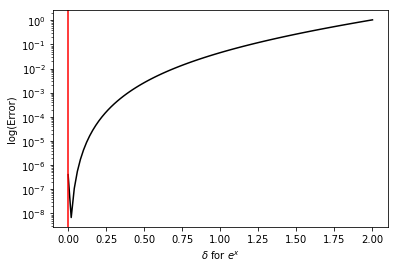

In [380]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

####################################### FOR e^(X)
def func(x):
    return np.exp(x)
def d_func(x):
    return np.exp(x)

def first_derivative(x,delta):
    return (func(x-2.0*delta)-8.0*func(x-delta)+8.0*func(x+delta)-func(x+2.0*delta))/(12.0*delta)

def function(delta):
    x = 0.2
    error = np.abs(first_derivative(x,delta)-d_func(x))
    return error

####################################### PLOTS

delta = 10**(-16.0/5.0)     # this is the optimal delta according to my calculation (approx)
deltas = np.linspace(1e-10,2,100)
errors = []

for i in range(len(deltas)):
    error1 = function(deltas[i])
    errors.append(error1)

plt.figure()
plt.plot(deltas,errors,"-", color="black")
plt.axvline(x=delta,color='red')
plt.yscale('log') 
#plt.xscale('log') 
plt.xlabel("$\delta$ for $e^{x}$")
plt.ylabel("log(Error)")
plt.show()        

However, in the case of $f(x) = e^{0.01x}$ the same minimum delta must be multiplied by a factor $10^2$, that comes form the fifth derivative:
\begin{equation}
\delta \sim  \Big(\frac{\varepsilon f(x)}{10^{-10}f'''''(x)}\Big)^{1/5} \sim \Big(\frac{\varepsilon f(x)}{f'''''(x)}\Big)^{1/5} \times 10^2
\end{equation}

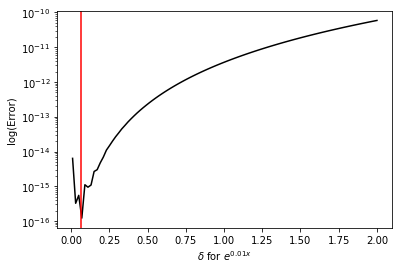

In [374]:
####################################### FOR 0.01*e^(X)
def func1(x):
    return np.exp(0.01*x)

def d_func1(x):
    return (0.01*np.exp(0.01*x))

def first_derivative1(x,delta):
    return (func1(x-2.0*delta)-8.0*func1(x-delta)+8.0*func1(x+delta)-func1(x+2.0*delta))/(12.0*delta)

def function1(delta):
    x = 10
    error = np.abs(first_derivative1(x,delta)-d_func1(x))
    return error
    
####################################### PLOTS
delta1 = (10**(-3.2))*10**2     # this is the optimal delta according to my calculation (approx)
deltas1 = np.linspace(1e-2,2,100)
errors1 = []

for i in range(len(deltas1)):
    error2 = function1(deltas1[i])
    errors1.append(error2)
    
plt.figure()
plt.plot(deltas1,errors1,"-", color="black")
plt.yscale('log')
#plt.xscale('log') 
plt.axvline(x=delta1,color='red')
plt.xlabel("$\delta$ for $e^{0.01x}$")
plt.ylabel("log(Error)")
plt.show()

In both cases, the optimal $\delta$ found is close to the minimum error.

## Problem 2

The temperature is 287.1576300609634 K  when random voltage is 0.5892212652815136 V, with approx error 0.05878769393598304 K


Text(0.5,0,'Voltage (V)')

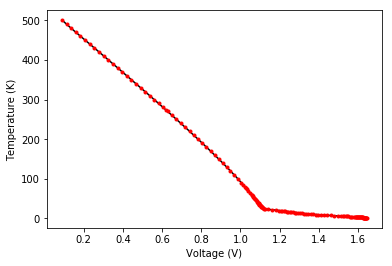

In [375]:
import random

temp,volt,dv_dt = np.loadtxt("lakeshore.txt", usecols=(0,1,2), unpack=True)
# First take an arbitrary voltage
random_volt = random.uniform(volt[0],volt[-1])

# I want to use cubicspline from scipy to interpolate
# the parameters are "x" (temperatures), "y" (voltages) and the "boundary condition type"
# The problem is we want the temperature given a voltage, so here we need the dependent variable
# and cubicspline gives you the independent variable.
# My idea: change x <-> y i.e. temperatures are now dependent of voltages
# The x argument in cubic splines must be in increasing order
# That is why I first sort the voltages to increasing order
# and sort the temperaures in decreasing order, so each point (temp,volt) is the same as before the sorting

volt=volt.tolist()                               # the sort works for lists
temp=temp.tolist()
volt_sort = sorted(volt)               # list to array again
temp_sort = sorted(temp,reverse=True)

cubicspline = CubicSpline(volt_sort,temp_sort,bc_type='not-a-knot')    # calculate the cubic spline


############################### ERROR CALCULATION ###############################
# The idea is to take only certain points of the array.
# I will use the points with odd index
# Let's say with the cubicspline1 I will get a point (v1,t1)
# Then, I will "fit" a cubic spline to the array with odd index
# and find a new point (v2,t2), but here v1=v2 since I'm trying to 
# find a temperature for one random voltage. The difference is that I'm using
# two cubicsplines.
# Finally, the error will be given by abs(t2-t1)
volt_odd = volt_sort[1::2]
temp_odd = temp_sort[1::2]
cubicspline_odd = CubicSpline(volt_odd,temp_odd,bc_type='not-a-knot')
error = np.abs(cubicspline_odd(random_volt)-cubicspline(random_volt))

print("The temperature is",cubicspline(random_volt),"K"," when random voltage is",random_volt,"V, with approx error",error, "K")



############################### PLOTTING ###############################
points = 200
X = np.linspace(volt_sort[0],volt_sort[-1],points)
plt.plot(X,cubicspline(X),linestyle="-",label="NaK Cubic Spline", color="black")
#plt.plot(X,cubicspline_odd(X),linestyle=" ", marker="*",label="NaK Cubic Spline")
plt.plot(volt_sort,temp_sort,".", color="red")
plt.ylabel("Temperature (K)")
plt.xlabel("Voltage (V)")



## Problem 3

The idea behind adaptive integration is to use the Simpson's rule varying the size step for each integration call. In the iteration, the function will call itself until the error between the left and right integrals becomes lower than certain threshold that I will give.

However, since this requires to evaluate f(x) in the same points x each time we call the function, the iteration will "loose" time on each call.
The idea is to save f(x) evaluations, since they were made in previous calls of the function.
So, the idea is to:
- create two lists that will save x [named xx] and f(x) [named yy] that are used in each call
- ask if we already evaluated f(x), this has 3 possible answers:
- (1) no, xx and yy are empty because it has no previous evaluations
- (2) no, xx is not saved so we have to use f(x) -> in this case we add n evaluations
- (3) yes, xx is saved so yy is also saved -> in this case we don't add evaluations, we just look for the value in xx and yy


In [376]:

# The funcion I want to integrate
def yourfunction(x):
    return 1.0/(1.0+x**2)

############################### LAZY INTEGRATOR ###############################
def lazyway(func,a,b,tol):
    x = np.linspace(a,b,5)
    y = func(x)
    # Simpson rule for points 0,2,4 (left,middle,right)
    simpson1 = (((y[0]+4*y[2]+y[4]))*(b-a))/6.0
    # Simpson rule for each point
    simpson2 = ((y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])*(b-a))/12.0
    # The error according to Simpson rule
    error = np.abs(simpson2-simpson1)/15.0
    neval= len(x)
    if error<tol:
        return (16.0*simpson2-simpson1)/15.0,error, neval
    else:
        # if the error is large, we want to use the function again
        # but using different points
        middle_point = (a+b)/2.0
        left_int,error_left,neval_left = lazyway(func,a,middle_point,tol/2.0)
        right_int,error_right,neval_right = lazyway(func,middle_point,b,tol/2.0)
        integral = left_int+right_int
        total_error = error_left+error_right
        total_neval = neval+neval_left+neval_right
        return integral, total_error, total_neval

############################### LESS LAZY INTEGRATOR ###############################

def lesslazy(func,a,b,tol,xx=[],yy=[]):
    # The five points with which we begin
    x = np.linspace(a,b,5)
    # y = f(x), the one we use in the simpson rule
    y = []
    # Lists that contain the x and y we already evaluated
    neval = 0
    # The first time the lists are empty, but we evaluate f(x) at points 0,1,2,3, 4, and 5. 
    # So neval starts at 0, we add the result of f(x) and x to the empty lists, and sum 5 evals
    if len(xx)==0:
        neval+=5
        for i in range(len(x)):
            xx.append(x[i])
            yy.append(func(x[i]))
            y.append(func(x[i]))
    if len(xx)>0:
    # If it's not the first time, we want to check if the value of x is already in the list xx
        for i in range(len(x)):
            # If x is in xx, we just append to yy f(x)
            if x[i] in xx:
                y.append(func(x[i]))
            # if x is not on xx, this means we have to call the function again
            else:
                yy.append(func(x[i]))
                xx.append(x[i])
                y.append(func(x[i]))
                neval+=1    
    # Simpson rule for points 0,2,4 (left,middle,right)
    simpson1 = (((y[0]+4*y[2]+y[4]))*(b-a))/6.0
    # Simpson rule for each point
    simpson2 = ((y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])*(b-a))/12.0
    # The error according to Simpson rule
    error = np.abs(simpson2-simpson1)/15.0
    if error<tol:
        return (16.0*simpson2-simpson1)/15.0,error, neval
    else:
        # if the error is large, we want to use the function again
        # but using different points
        middle_point = (a+b)/2.0
        left_int,error_left,neval_left = lesslazy(func,a,middle_point,tol/2.0,xx,yy)
        right_int,error_right,neval_right = lesslazy(func,middle_point,b,tol/2.0,xx,yy)
        integral = left_int+right_int
        total_error = error_left+error_right
        total_neval = neval+neval_left+neval_right
        return integral, total_error, total_neval

integral, error, neval = lazyway(yourfunction,1,10,1e-10)
print("The value of the integral is",integral,"after",neval,"calls, with error",error)
integral2, error2, neval2 = lesslazy(yourfunction,1,10,1e-10)
print("The value of the integral is",integral2, "after",neval2,"calls, with error", error2)   


The value of the integral is 0.6857295109062883 after 1625 calls, with error 3.324680941431864e-11
The value of the integral is 0.6857295109062883 after 653 calls, with error 3.324680941431864e-11


## Problem 4
griffiths 2.7 solution here https://www.physicsisbeautiful.com/resources/introduction-to-electrodynamics/problems/2.7/solutions/2.7-2.8.pdf/gTkMTWTatStZcqFYqG3RFb/

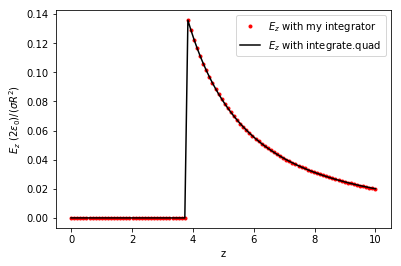

In [378]:

from scipy import integrate
import random
import sys
sys.setrecursionlimit(13000)

# A modified version of the code in problem 3, to use in this problem
def variablestep2(a,b,tol,z,R):
    x = np.linspace(a,b,5)
    y = (z-R*x)/(R**2.+z**2.-2.*R*z*x)**(3./2.)
    simpson1 = (((y[0]+4.*y[2]+y[4]))*(b-a))/6.0
    simpson2 = ((y[0]+4.*y[1]+2.*y[2]+4.*y[3]+y[4])*(b-a))/12.0
    error = np.abs(simpson2-simpson1)/15.0
    neval= len(x)
    if error<tol:
        return (16.0*simpson2-simpson1)/15.0,error, neval
    else:
        middle_point = (a+b)/2.0
        left_int,error_left,neval_left = variablestep2(a,middle_point,tol/2.0,z,R)
        right_int,error_right,neval_right = variablestep2(middle_point,b,tol/2.0,z,R)
        integral = left_int+right_int
        total_error = error_left+error_right
        total_neval = neval+neval_left+neval_right
        return integral, total_error, total_neval
    
# The function to be integrated according to Griffiths 2.7 solution

def func(u,z,R):
    argument = (z-R*u)/(R**2.+z**2.-2.*R*z*u)**(3./2.)
    return argument

# The electric field at a distance z of a spherical surface of charge with radius R
# is given by integral in integrate.quad
# First I give a range of values for z

z = np.linspace(0,10,100)

# And choose an arbitrary R from the list of z's, so one of the z values IS R

R = random.uniform(z[0],z[-1])

# list with the electric fields after integration
E_z = []
E_z_myintegrator = []

# integrate, or calculate the electric field for each z[i] in z
for i in range(len(z)):
    arg = integrate.quad(func, -1, 1,args=(z[i],R))  # returns the value of the integral and the error
    integral, error, neval = variablestep2(-1,1,1e-5,z[i],R)
    E_z.append(arg[0])
    E_z_myintegrator.append(integral)

plt.plot(z,E_z_myintegrator,".", color = "red", label="$E_z$ with my integrator")
plt.plot(z,E_z,"-", color = "black", label = "$E_z$ with integrate.quad")
plt.xlabel("z")
plt.ylabel("$E_z$ $(2\epsilon_{0})/(\sigma R^{2})$")
plt.legend(loc="best")
plt.show()


As can be seen from the plot, neither of the integrators cares about the singularity. The singularity must occur when $z = R$, because the electric field depends on the factor:
\begin{equation}
E_z \propto \Bigg[\frac{z-R}{|z-R|}-\frac{-z-R}{|z+R|}\Bigg]
\end{equation}
according to Griffiths problem 2.7 solution.
I think this happens because of the machine precision, i.e., the subtraction $z-R$ is not exactly 0, so it is like it never was a real division by 0 or singularity.